In [239]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m
import notears.notears.notears.utils as utils
import notears.notears.notears.linear as linear
from timeit import default_timer as timer
from importlib import reload  # Python 3.4+

reload(m)

<module 'helper.methods' from '..\\helper\\methods.py'>

### Compare Running times of OMP and K-OMP
Expected Complexity: $O(T p^2)$ for OMP.

Expected Complexity: $O(p^2)$ for K-OMP.

Expected Complexity: $O(T p^3)$ for NOTEARS.
#### Generate Data

True W:
[[ 0.    0.9   0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.8   0.   -0.78  0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [-0.85 -0.82  0.    0.    0.  ]].



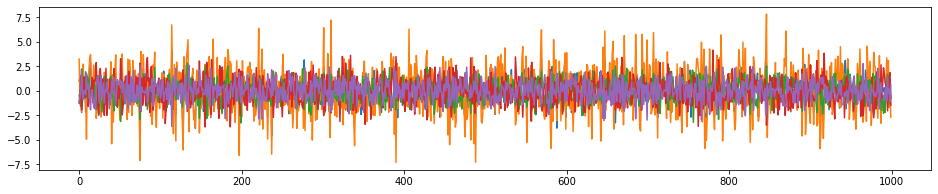

In [333]:
# set random seed
# utils.set_random_seed(1)

# print W
T, n, s0, graph_type, sem_type = 1000, 5, 5, 'ER', 'gauss'
W_true = utils.simulate_parameter(utils.simulate_dag(n, s0, graph_type), w_ranges = ((-1.0, -0.75), (0.75, 1.0)))
print(f"True W:\n{np.round(W_true, 2)}.\n")

# plot X
X = utils.simulate_linear_sem(W_true, T, sem_type)
plt.figure(figsize=(16, 3))
plt.plot(X);

#### Time OMP

In [334]:
def time_OMP_SEM(X):
    start = timer()
    m._OMP_SEM(X, tol = 1e-8)
    return timer() - start

print(f"Time Elapsed: {round(time_OMP_SEM(X), 3)} seconds.")

Time Elapsed: 0.037 seconds.


#### Time K-OMP

In [335]:
reload(m)

def time_KOMP_SEM(X):
    start = timer()
    m._K_OMP(X, X, tol = 1e-8, is_sem = True, normalize = True)
    return timer() - start

print(f"Time Elapsed: {round(time_KOMP_SEM(X), 3)} seconds.")

Time Elapsed: 0.01 seconds.


#### Time NOTEARS

In [337]:
def time_NOTEARS_SEM(X):
    start = timer()
    W, h_val = m._notears_2(X, loss_type = "l2")
    return timer() - start

print(f"Time Elapsed: {round(time_NOTEARS_SEM(X), 3)} seconds.")

Time Elapsed: 2.041 seconds.


### Vary time horizon $T$

In [311]:
def vary_T(Ts, n_iters, p):
    """
    Vary Time Horizon T for all T in Ts, and check computation time.
    We do each T in Ts for n_iters time for stability.
    We use p variables for each simulation
    """
    
    # Times list
    KOMP_times = [[] for _ in range(len(Ts))]
    OMP_times = [[] for _ in range(len(Ts))]
    NOTEARS_times = [[] for _ in range(len(Ts))]

    # for each Timestep T
    for i, T in tqdm(enumerate(Ts)):
        
        # number of edges
        s0 = p
        
        # generate true W
        W_true = utils.simulate_parameter(utils.simulate_dag(p, s0, graph_type), w_ranges = ((-1.0, -0.75), (0.75, 1.0)))
        
        # number of iterations per p
        for j in range(n_iters):
            
            # generate data
            X = utils.simulate_linear_sem(W_true, T, sem_type)
            
            # KOMP
            KOMP_times[i].append(time_KOMP_SEM(X))
            
            # OMP
            OMP_times[i].append(time_OMP_SEM(X))
            
            # NOTEARS
            NOTEARS_times[i].append(time_NOTEARS_SEM(X))
    
    # return the times
    return KOMP_times, OMP_times, NOTEARS_times

In [440]:
Ts = [5000, 10000, 15000, 20000, 25000]
n_iters = 5
p = 5

KOMP_times_t, OMP_times_t, NOTEARS_times_t = vary_T(Ts, n_iters, p)
log_KOMP_times_t, log_OMP_times_t, log_NOTEARS_times_t = np.log10(KOMP_times_t), np.log10(OMP_times_t), np.log10(NOTEARS_times_t)

0it [00:00, ?it/s]..\notears\notears\notears\linear.py:73: RuntimeWarning: overflow encountered in double_scalars
  obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
..\notears\notears\notears\linear.py:74: RuntimeWarning: overflow encountered in multiply
  G_smooth = G_loss + (rho * h + alpha) * G_h
5it [01:42, 20.51s/it]


#### Plotting running time for varying $T$ in Regular Scale

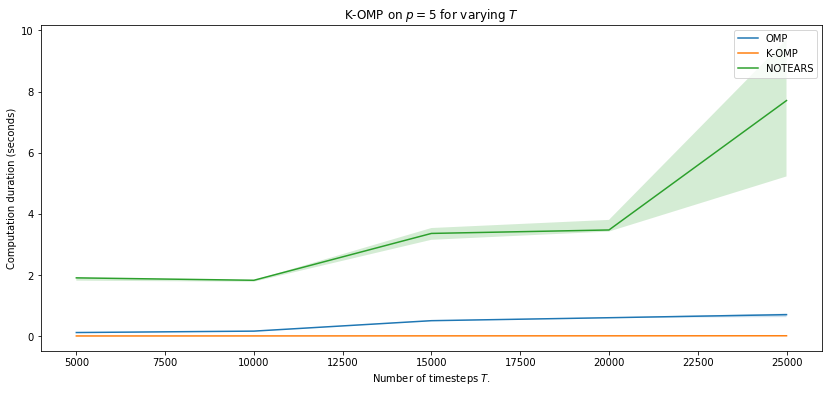

In [441]:
plt.figure(figsize = (14, 6))
plt.title(f"K-OMP on $p = {p}$ for varying $T$")
plt.xlabel("Number of timesteps $T$.")
plt.ylabel("Computation duration (seconds)")
plt.plot(Ts, np.mean(np.array(OMP_times_t), axis = 1), label = "OMP")
plt.fill_between(Ts, np.percentile(OMP_times_t, 25, axis = 1), np.percentile(OMP_times_t, 75, axis = 1), alpha=0.2)
plt.plot(Ts, np.median(np.array(KOMP_times_t), axis = 1), label = "K-OMP")
plt.fill_between(Ts, np.percentile(KOMP_times_t, 25, axis = 1), np.percentile(KOMP_times_t, 75, axis = 1), alpha=0.2)
plt.plot(Ts, np.median(np.array(NOTEARS_times_t), axis = 1), label = "NOTEARS")
plt.fill_between(Ts, np.percentile(NOTEARS_times_t, 25, axis = 1), np.percentile(NOTEARS_times_t, 75, axis = 1), alpha=0.2)
plt.legend();

#### Plot running time for varying $T$ in Log Scale

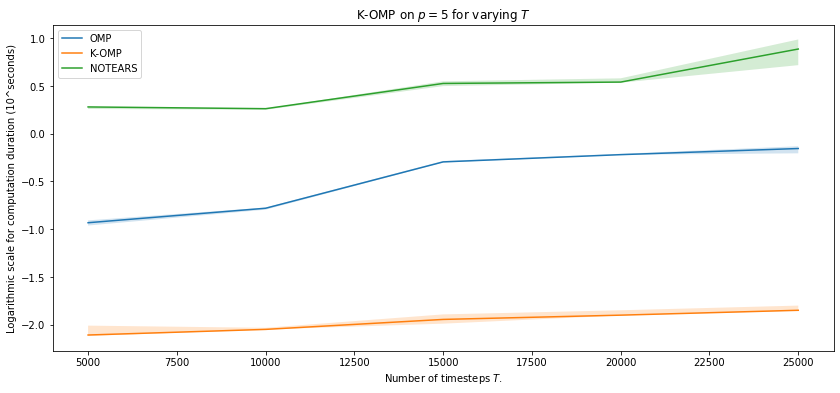

In [442]:
plt.figure(figsize = (14, 6))
plt.title(f"K-OMP on $p = {p}$ for varying $T$")
plt.xlabel("Number of timesteps $T$.")
plt.ylabel("Logarithmic scale for computation duration (10^seconds)")
plt.plot(Ts, np.mean(np.array(log_OMP_times_t), axis = 1), label = "OMP")
plt.fill_between(Ts, np.percentile(log_OMP_times_t, 25, axis = 1), np.percentile(log_OMP_times_t, 75, axis = 1), alpha=0.2)
plt.plot(Ts, np.median(np.array(log_KOMP_times_t), axis = 1), label = "K-OMP")
plt.fill_between(Ts, np.percentile(log_KOMP_times_t, 25, axis = 1), np.percentile(log_KOMP_times_t, 75, axis = 1), alpha=0.2)
plt.plot(Ts, np.median(np.array(log_NOTEARS_times_t), axis = 1), label = "NOTEARS")
plt.fill_between(Ts, np.percentile(log_NOTEARS_times_t, 25, axis = 1), np.percentile(log_NOTEARS_times_t, 75, axis = 1), alpha=0.2)
plt.legend();

### Vary number of variables $p$

In [302]:
def vary_P(Ps, n_iters, T):
    """
    Vary number of variables p for all p in Ps, and check computation time.
    We do each p in Ps for n_iters time for stability.
    We use T timesteps for each simulation
    """
    
    # Times list
    KOMP_times = [[] for _ in range(len(Ps))]
    OMP_times = [[] for _ in range(len(Ps))]
    NOTEARS_times = [[] for _ in range(len(Ps))]

    # for each number of variables
    for i, p in tqdm(enumerate(Ps)):
        
        # number of edges
        s0 = p
        
        # generate true W
        W_true = utils.simulate_parameter(utils.simulate_dag(p, s0, graph_type), w_ranges = ((-1.0, -0.75), (0.75, 1.0)))
        
        # number of iterations per p
        for j in range(n_iters):
            
            # generate data
            X = utils.simulate_linear_sem(W_true, T, sem_type)
            
            # KOMP
            KOMP_times[i].append(time_KOMP_SEM(X))
            
            # OMP
            OMP_times[i].append(time_OMP_SEM(X))
            
            # NOTEARS
            NOTEARS_times[i].append(time_NOTEARS_SEM(X))
    
    # return times
    return KOMP_times, OMP_times, NOTEARS_times

In [343]:
Ps = [3, 5, 7, 10]
n_iters = 5

T = 1000
KOMP_times_p, OMP_times_p, NOTEARS_times_p = vary_P(Ps, n_iters, T)
log_KOMP_times_p, log_OMP_times_p, log_NOTEARS_times_p = np.log10(KOMP_times_p), np.log10(OMP_times_p), np.log10(NOTEARS_times_p)

3it [00:34, 13.29s/it]..\notears\notears\notears\linear.py:73: RuntimeWarning: overflow encountered in double_scalars
  obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
..\notears\notears\notears\linear.py:74: RuntimeWarning: overflow encountered in multiply
  G_smooth = G_loss + (rho * h + alpha) * G_h
4it [01:16, 19.10s/it]


#### Plot running time for varying $p$ in Regular Scale

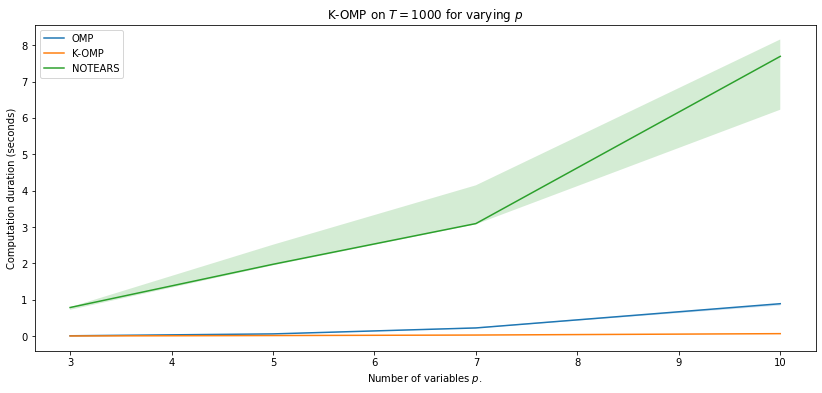

In [345]:
plt.figure(figsize = (14, 6))
plt.title(f"K-OMP on $T = {T}$ for varying $p$")
plt.xlabel("Number of variables $p$.")
plt.ylabel("Computation duration (seconds)")
plt.plot(Ps, np.median(np.array(OMP_times_p), axis = 1), label = "OMP")
plt.fill_between(Ps, np.percentile(OMP_times_p, 25, axis = 1), np.percentile(OMP_times_p, 75, axis = 1), alpha=0.2)
plt.plot(Ps, np.median(np.array(KOMP_times_p), axis = 1), label = "K-OMP")
plt.fill_between(Ps, np.percentile(KOMP_times_p, 25, axis = 1), np.percentile(KOMP_times_p, 75, axis = 1), alpha=0.2)
plt.plot(Ps, np.median(np.array(NOTEARS_times_p), axis = 1), label = "NOTEARS")
plt.fill_between(Ps, np.percentile(NOTEARS_times_p, 25, axis = 1), np.percentile(NOTEARS_times_p, 75, axis = 1), alpha=0.2)
plt.legend();

#### Plot running time for varying $p$ in Log Scale

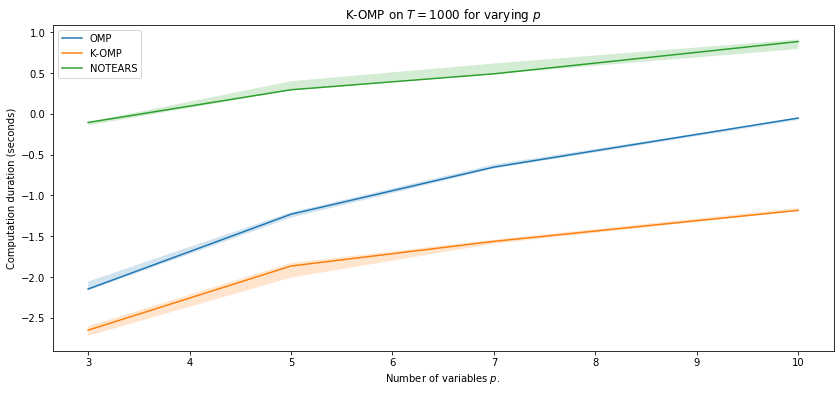

In [434]:
plt.figure(figsize = (14, 6))
plt.title(f"K-OMP on $T = {T}$ for varying $p$")
plt.xlabel("Number of variables $p$.")
plt.ylabel("Computation duration (seconds)")
plt.plot(Ps, np.median(np.array(log_OMP_times_p), axis = 1), label = "OMP")
plt.fill_between(Ps, np.percentile(log_OMP_times_p, 25, axis = 1), np.percentile(log_OMP_times_p, 75, axis = 1), alpha=0.2)
plt.plot(Ps, np.median(np.array(log_KOMP_times_p), axis = 1), label = "K-OMP")
plt.fill_between(Ps, np.percentile(log_KOMP_times_p, 25, axis = 1), np.percentile(log_KOMP_times_p, 75, axis = 1), alpha=0.2)
plt.plot(Ps, np.median(np.array(log_NOTEARS_times_p), axis = 1), label = "NOTEARS")
plt.fill_between(Ps, np.percentile(log_NOTEARS_times_p, 25, axis = 1), np.percentile(log_NOTEARS_times_p, 75, axis = 1), alpha=0.2)
plt.legend();

In [436]:
def max_P(T, t_max):
    
    p = 3
    
    t_KOMP, t_OMP, t_NOTEARS = 0, 0, 0
    
    KOMP_times, OMP_times, NOTEARS_times = [], [], []
    
    while t_NOTEARS <= t_max:
    
        # number of edges
        s0 = p
    
        # generate true W
        W_true = utils.simulate_parameter(utils.simulate_dag(p, s0, graph_type), w_ranges = ((-1.0, -0.75), (0.75, 1.0)))
    
        # generate data
        X = utils.simulate_linear_sem(W_true, T, sem_type)
    
        t_OMP = time_KOMP_SEM(X)
        KOMP_times.append(t_KOMP)
        
        t_OMP = time_OMP_SEM(X)
        OMP_times.append(t_OMP)
        
        t_NOTEARS = time_NOTEARS_SEM(X)
        NOTEARS_times.append(t_NOTEARS)
        
        print(round(t_NOTEARS, 3))
    
        p += 1
        
    while t_OMP <= t_max:
    
        # number of edges
        s0 = p
    
        # generate true W
        W_true = utils.simulate_parameter(utils.simulate_dag(p, s0, graph_type), w_ranges = ((-1.0, -0.75), (0.75, 1.0)))
    
        # generate data
        X = utils.simulate_linear_sem(W_true, T, sem_type)
    
        t_KOMP = time_KOMP_SEM(X)
        KOMP_times.append(t_KOMP)
        
        t_OMP = time_OMP_SEM(X)
        OMP_times.append(t_OMP)
        
        print(round(t_OMP, 3))
    
        p += 1
        
    while t_KOMP <= t_max:
    
        # number of edges
        s0 = p
    
        # generate true W
        W_true = utils.simulate_parameter(utils.simulate_dag(p, s0, graph_type), w_ranges = ((-1.0, -0.75), (0.75, 1.0)))
    
        # generate data
        X = utils.simulate_linear_sem(W_true, T, sem_type)
    
        t_KOMP = time_KOMP_SEM(X)
        KOMP_times.append(t_KOMP)
        
        print(round(t_KOMP, 3))
    
        p += 1
    
    return NOTEARS_times, OMP_times, KOMP_times

NT_p, OMP_p, KOMP_p = max_P(1000, 5)

0.749
1.171
2.017
3.044
2.517
4.009
5.98
0.993
2.097
2.586
3.542
4.907
6.806
0.357
0.451
0.486
0.658
0.685
0.775
1.018
1.32
1.328
1.575
1.842
1.969
2.32
2.953
3.512
4.053
3.564
3.951
3.434
3.897
4.027
5.086


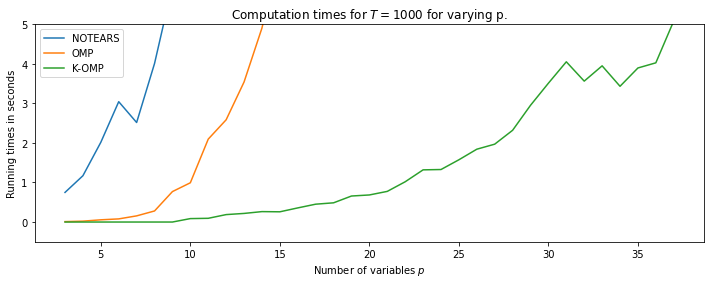

In [443]:
plt.figure(figsize = (12, 4))
plt.ylim(-0.5, 5)
plt.plot(range(3, 3 + len(NT_p)), NT_p, label = "NOTEARS")
plt.plot(range(3, 3 + len(OMP_p)), OMP_p, label = "OMP")
plt.plot(range(3, 3 + len(KOMP_p)), KOMP_p, label = "K-OMP")
plt.ylabel("Running times in seconds")
plt.xlabel("Number of variables $p$")
plt.title(f"Computation times for $T = {T}$ for varying p.")
plt.legend()

In [424]:
def max_T(p, t_max):
    
    T = 500
    
    t_KOMP, t_OMP, t_NOTEARS = 0, 0, 0
    
    KOMP_times, OMP_times, NOTEARS_times = [], [], []
    
    print("NOTEARS:", end = "\t")
    while t_NOTEARS <= t_max:
        
        # number of edges
        s0 = p
    
        # generate true W
        W_true = utils.simulate_parameter(utils.simulate_dag(p, s0, graph_type), w_ranges = ((-1.0, -0.75), (0.75, 1.0)))
    
        # generate data
        X = utils.simulate_linear_sem(W_true, T, sem_type)
    
        t_OMP = time_KOMP_SEM(X)
        KOMP_times.append(t_KOMP)
        
        t_OMP = time_OMP_SEM(X)
        OMP_times.append(t_OMP)
        
        t_NOTEARS = time_NOTEARS_SEM(X)
        NOTEARS_times.append(t_NOTEARS)
        
        print(round(t_NOTEARS, 1), end = "\t")
    
        T += 5000
        
    print("OMP:", end = "\t")
    
    while t_OMP <= t_max:
        
        # number of edges
        s0 = p
    
        # generate true W
        W_true = utils.simulate_parameter(utils.simulate_dag(p, s0, graph_type), w_ranges = ((-1.0, -0.75), (0.75, 1.0)))
    
        # generate data
        X = utils.simulate_linear_sem(W_true, T, sem_type)
    
        t_KOMP = time_KOMP_SEM(X)
        KOMP_times.append(t_KOMP)
        
        t_OMP = time_OMP_SEM(X)
        OMP_times.append(t_OMP)
        
        print(round(t_OMP, 1), end = "\t")
    
        T += 10000
        
    print("KOMP:", end = "\t")
    while t_KOMP <= t_max / 5:
        
        # number of edges
        s0 = p
    
        # generate true W
        W_true = utils.simulate_parameter(utils.simulate_dag(p, s0, graph_type), w_ranges = ((-1.0, -0.75), (0.75, 1.0)))
    
        # generate data
        X = utils.simulate_linear_sem(W_true, T, sem_type)
    
        t_KOMP = time_KOMP_SEM(X)
        KOMP_times.append(t_KOMP)
        
        print(round(t_KOMP, 1), end = "\t")
    
        T += 500000
    
    return NOTEARS_times, OMP_times, KOMP_times

NT_t, OMP_t, KOMP_t = max_T(5, 5)

NOTEARS:	2.2	

..\notears\notears\notears\linear.py:73: RuntimeWarning: overflow encountered in double_scalars
  obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
..\notears\notears\notears\linear.py:74: RuntimeWarning: overflow encountered in multiply
  G_smooth = G_loss + (rho * h + alpha) * G_h


2.2	2.3	5.3	OMP:	0.7	1.1	1.4	1.6	1.8	3.3	2.8	3.2	3.0	4.5	4.4	5.6	KOMP:	0.0	0.1	0.1	0.1	0.2	0.2	0.3	0.3	0.4	0.4	0.4	0.5	0.5	0.6	0.6	0.6	0.7	1.0	

In [425]:
r1 = np.linspace(50, 50 + 5000 * (len(NT_t) - 1), len(NT_t))
r2 = np.linspace(r1[-1] + 10000, r1[-1] + 10000 * (len(OMP_t) - len(NT_t)), len(OMP_t) - len(NT_t))
r3 = np.linspace(r2[-1] + 500000, r2[-1] + 500000 * (len(KOMP_t) - len(OMP_t)), len(KOMP_t) - len(OMP_t))
print(r1)
print(r2)
print(r3)

[   50.  5050. 10050. 15050.]
[ 25050.  35050.  45050.  55050.  65050.  75050.  85050.  95050. 105050.
 115050. 125050. 135050.]
[ 635050. 1135050. 1635050. 2135050. 2635050. 3135050. 3635050. 4135050.
 4635050. 5135050. 5635050. 6135050. 6635050. 7135050. 7635050. 8135050.
 8635050. 9135050.]


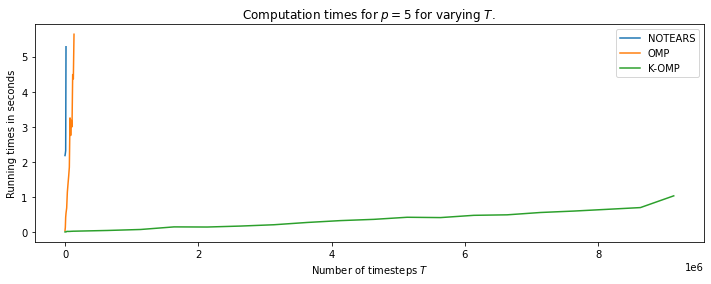

In [444]:
# plt.ylim(-0.5, 5)
plt.figure(figsize = (12, 4))
plt.plot(r1, NT_t, label = "NOTEARS")
plt.plot(np.append(r1, r2), OMP_t, label = "OMP")
plt.plot(np.append(r1, np.append(r2, r3)), KOMP_t, label = "K-OMP")
plt.title(r"Computation times for $p = 5$ for varying $T$.")
plt.ylabel("Running times in seconds")
plt.xlabel("Number of timesteps $T$")
plt.legend()